In [38]:
import itertools
import math
import time 

import torch 
import torch.nn as nn
import torch.nn.functional as F

import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as trans

%matplotlib inline
import matplotlib.pyplot as plt

BATCH_SIZE = 100
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# 将每个像素值scale到[-1, 1]t
transform = trans.Compose([
    trans.ToTensor(),
    trans.Normalize(mean=(0.5,),std=(0.5,))
])

# 加载MNIST数据集
train_set = dset.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)

- 定义判别器
   - 784->256->256->[0,1]

In [39]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.F = nn.Sequential(
            nn.Linear(784,256),nn.ReLU(),
            nn.Linear(256,256),nn.ReLU(),
            nn.Linear(256,1),nn.Sigmoid())
    def forward(self,x):
        x = x.view(x.size(0),-1)
        return self.F(x)

- 定义生成器
  - z->256->256->784

In [40]:
class Generator(nn.Module):
    def __init__ (self,z_dim=20):
        super(Generator, self).__init__()
        self.F = nn.Sequential(
            nn.Linear(z_dim,256),nn.ReLU(),
            nn.Linear(256,256),nn.ReLU(),
            nn.Linear(256,784),nn.Tanh())
    
    def forward(self,x):
        x = self.F(x)
        x = x.view(x.size(0),28,28)
        return x

准备相关变量1

In [41]:
z_dim = 20
netD = Discriminator().to(device)
netG = Generator(z_dim).to(device)

optimizerD= torch.optim.SGD(netD.parameters(),lr=5e-4,momentum=0.9)
optimizerG= torch.optim.RMSprop(netG.parameters(),lr=5e-4)
nepochs = 50

criterion = nn.BCELoss()
one = torch.ones(BATCH_SIZE,1).to(device)
zero = torch.zeros(BATCH_SIZE,1).to(device)

In [42]:
acc_r = []
acc_f = []
for epoch in range(nepochs):
    since = time.time()
    for batch_x, _ in dataloader:
        real_size = batch_x.size(0)
        real_x = batch_x.to(device)
    
        # 更新判别器
        z = torch.randn(BATCH_SIZE,z_dim).to(device)
        fake_x = netG(z)
        
        # 计算判别器的损失
        optimizerD.zero_grad()
        real_y = netD(real_x)
        fake_y = netD(fake_x)
        
        rea_label = torch.ones(real_size,1).to(device)
        fake_label = torch.zeros(real_size,1).to(device)
        
        errorD_real = criterion(real_y,rea_label)
        errorD_fake = criterion(fake_y,fake_label)
        
        errorD = errorD_real + errorD_fake
        errorD.backward()
        optimizerD.step()
        
        acc_r.append(real_y.mean().item())
        acc_f.append(fake_y.mean().item())
        
        # 更新生成器
        optimizerG.zero_grad()
        z = torch.randn(real_size,z_dim).to(device)
        fake_x = netG(z)
        fake_y = netD(fake_x)
        errorG = criterion(fake_y,rea_label)
        errorG.backward()
        optimizerG.step()
        
    now = time.time()
    print('[%d/%d, %.0f seconds]|\t err_D: %.4f \t err_G: %.4f' % (epoch, nepochs, now-since, errorD.item(), errorG.item()))
    

[0/50, 10 seconds]|	 err_D: 1.4066 	 err_G: 0.6993
[1/50, 11 seconds]|	 err_D: 1.3954 	 err_G: 0.6942
[2/50, 10 seconds]|	 err_D: 1.3957 	 err_G: 0.7117
[3/50, 10 seconds]|	 err_D: 1.3923 	 err_G: 0.7108
[4/50, 10 seconds]|	 err_D: 1.3931 	 err_G: 0.6981
[5/50, 10 seconds]|	 err_D: 1.3957 	 err_G: 0.7003
[6/50, 9 seconds]|	 err_D: 1.4022 	 err_G: 0.6604
[7/50, 10 seconds]|	 err_D: 1.3928 	 err_G: 0.6834
[8/50, 10 seconds]|	 err_D: 1.3924 	 err_G: 0.6821
[9/50, 10 seconds]|	 err_D: 1.3976 	 err_G: 0.6666
[10/50, 10 seconds]|	 err_D: 1.3931 	 err_G: 0.7022
[11/50, 10 seconds]|	 err_D: 1.3914 	 err_G: 0.6993
[12/50, 10 seconds]|	 err_D: 1.3900 	 err_G: 0.7013
[13/50, 11 seconds]|	 err_D: 1.3898 	 err_G: 0.7125
[14/50, 10 seconds]|	 err_D: 1.3892 	 err_G: 0.6886
[15/50, 10 seconds]|	 err_D: 1.3913 	 err_G: 0.6918
[16/50, 10 seconds]|	 err_D: 1.3875 	 err_G: 0.6843
[17/50, 10 seconds]|	 err_D: 1.3911 	 err_G: 0.6727
[18/50, 10 seconds]|	 err_D: 1.3895 	 err_G: 0.6820
[19/50, 10 seconds]|	 e

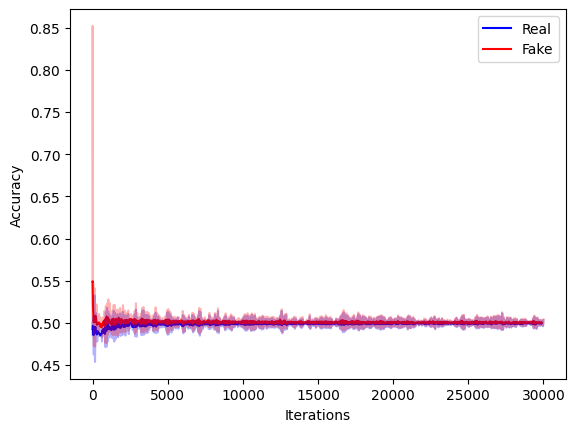

In [44]:
import numpy as np

# Smooth the curve
def smooth_data(x,ksize=5):
    kernel = np.ones(ksize)/ksize
    x_smooth = np.convolve(x,kernel,mode='valid')
    return x_smooth

acc_r_smooth = smooth_data(acc_r,120)
acc_f_smooth = smooth_data(acc_f,120)

plt.plot(acc_r_smooth,'-b',label='Real')
plt.plot(acc_f_smooth,'-r',label='Fake')
plt.plot(acc_r,'-b',alpha=0.3)
plt.plot(acc_f,'-r',alpha=0.3)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()

准备相关变量2

In [47]:
z_dim = 20
netD = Discriminator().to(device)
netG = Generator(z_dim).to(device)

optimizerD= torch.optim.SGD(netD.parameters(),lr=1e-3,momentum=0.9)
optimizerG= torch.optim.RMSprop(netG.parameters(),lr=1e-3)
nepochs = 15

criterion = nn.BCELoss()
one = torch.ones(BATCH_SIZE,1).to(device)
zero = torch.zeros(BATCH_SIZE,1).to(device)

acc_r = []
acc_f = []
for epoch in range(nepochs):
    since = time.time()
    for batch_x, _ in dataloader:
        real_size = batch_x.size(0)
        real_x = batch_x.to(device)
    
        # 更新判别器
        z = torch.randn(BATCH_SIZE,z_dim).to(device)
        fake_x = netG(z)
        
        # 计算判别器的损失
        optimizerD.zero_grad()
        real_y = netD(real_x)
        fake_y = netD(fake_x)
        
        rea_label = torch.ones(real_size,1).to(device)
        fake_label = torch.zeros(real_size,1).to(device)
        
        errorD_real = criterion(real_y,rea_label)
        errorD_fake = criterion(fake_y,fake_label)
        
        errorD = errorD_real + errorD_fake
        errorD.backward()
        optimizerD.step()
        
        acc_r.append(real_y.mean().item())
        acc_f.append(fake_y.mean().item())
        
        # 更新生成器
        optimizerG.zero_grad()
        z = torch.randn(real_size,z_dim).to(device)
        fake_x = netG(z)
        fake_y = netD(fake_x)
        errorG = criterion(fake_y,rea_label)
        errorG.backward()
        optimizerG.step()
        
    now = time.time()
    print('[%d/%d, %.0f seconds]|\t err_D: %.4f \t err_G: %.4f' % (epoch, nepochs, now-since, errorD.item(), errorG.item()))
    


[0/15, 10 seconds]|	 err_D: 1.4187 	 err_G: 0.6824
[1/15, 10 seconds]|	 err_D: 1.3965 	 err_G: 0.7077
[2/15, 10 seconds]|	 err_D: 1.3945 	 err_G: 0.6927
[3/15, 11 seconds]|	 err_D: 1.3915 	 err_G: 0.7000
[4/15, 10 seconds]|	 err_D: 1.3942 	 err_G: 0.6873
[5/15, 11 seconds]|	 err_D: 1.3957 	 err_G: 0.6758
[6/15, 11 seconds]|	 err_D: 1.3899 	 err_G: 0.6951
[7/15, 10 seconds]|	 err_D: 1.3906 	 err_G: 0.7054
[8/15, 10 seconds]|	 err_D: 1.3878 	 err_G: 0.6915
[9/15, 11 seconds]|	 err_D: 1.3940 	 err_G: 0.6888
[10/15, 11 seconds]|	 err_D: 1.3879 	 err_G: 0.7015
[11/15, 10 seconds]|	 err_D: 1.3887 	 err_G: 0.6882
[12/15, 9 seconds]|	 err_D: 1.3867 	 err_G: 0.6986
[13/15, 10 seconds]|	 err_D: 1.3892 	 err_G: 0.6901
[14/15, 10 seconds]|	 err_D: 1.3877 	 err_G: 0.6877


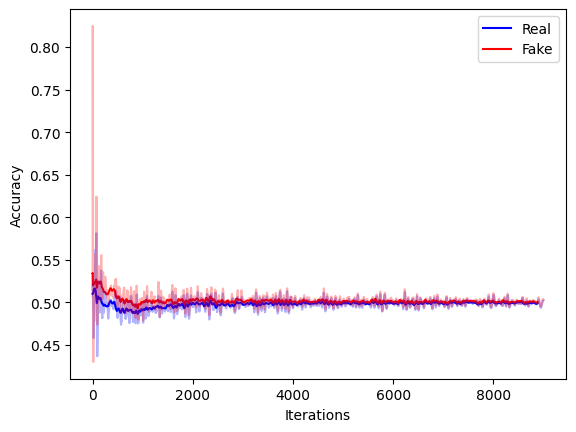

In [48]:
import numpy as np

# Smooth the curve
def smooth_data(x,ksize=5):
    kernel = np.ones(ksize)/ksize
    x_smooth = np.convolve(x,kernel,mode='valid')
    return x_smooth

acc_r_smooth = smooth_data(acc_r,120)
acc_f_smooth = smooth_data(acc_f,120)

plt.plot(acc_r_smooth,'-b',label='Real')
plt.plot(acc_f_smooth,'-r',label='Fake')
plt.plot(acc_r,'-b',alpha=0.3)
plt.plot(acc_f,'-r',alpha=0.3)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()

In [49]:
z_dim = 20
netD = Discriminator().to(device)
netG = Generator(z_dim).to(device)

optimizerD= torch.optim.SGD(netD.parameters(),lr=5e-6,momentum=0.9)
optimizerG= torch.optim.RMSprop(netG.parameters(),lr=5e-6)
nepochs = 15

criterion = nn.BCELoss()
one = torch.ones(BATCH_SIZE,1).to(device)
zero = torch.zeros(BATCH_SIZE,1).to(device)

acc_r = []
acc_f = []
for epoch in range(nepochs):
    since = time.time()
    for batch_x, _ in dataloader:
        real_size = batch_x.size(0)
        real_x = batch_x.to(device)
    
        # 更新判别器
        z = torch.randn(BATCH_SIZE,z_dim).to(device)
        fake_x = netG(z)
        
        # 计算判别器的损失
        optimizerD.zero_grad()
        real_y = netD(real_x)
        fake_y = netD(fake_x)
        
        rea_label = torch.ones(real_size,1).to(device)
        fake_label = torch.zeros(real_size,1).to(device)
        
        errorD_real = criterion(real_y,rea_label)
        errorD_fake = criterion(fake_y,fake_label)
        
        errorD = errorD_real + errorD_fake
        errorD.backward()
        optimizerD.step()
        
        acc_r.append(real_y.mean().item())
        acc_f.append(fake_y.mean().item())
        
        # 更新生成器
        optimizerG.zero_grad()
        z = torch.randn(real_size,z_dim).to(device)
        fake_x = netG(z)
        fake_y = netD(fake_x)
        errorG = criterion(fake_y,rea_label)
        errorG.backward()
        optimizerG.step()
        
    now = time.time()
    print('[%d/%d, %.0f seconds]|\t err_D: %.4f \t err_G: %.4f' % (epoch, nepochs, now-since, errorD.item(), errorG.item()))
    


[0/15, 10 seconds]|	 err_D: 1.4945 	 err_G: 0.4831
[1/15, 10 seconds]|	 err_D: 1.6634 	 err_G: 0.3629
[2/15, 9 seconds]|	 err_D: 1.5062 	 err_G: 0.4494
[3/15, 10 seconds]|	 err_D: 1.3104 	 err_G: 0.5803
[4/15, 10 seconds]|	 err_D: 1.2382 	 err_G: 0.6292
[5/15, 11 seconds]|	 err_D: 1.2247 	 err_G: 0.6217
[6/15, 10 seconds]|	 err_D: 1.2296 	 err_G: 0.6153
[7/15, 9 seconds]|	 err_D: 1.2124 	 err_G: 0.6180
[8/15, 10 seconds]|	 err_D: 1.2144 	 err_G: 0.6115
[9/15, 10 seconds]|	 err_D: 1.2524 	 err_G: 0.5982
[10/15, 10 seconds]|	 err_D: 1.3258 	 err_G: 0.5658
[11/15, 10 seconds]|	 err_D: 1.4067 	 err_G: 0.5352
[12/15, 9 seconds]|	 err_D: 1.4622 	 err_G: 0.5281
[13/15, 10 seconds]|	 err_D: 1.4704 	 err_G: 0.5400
[14/15, 10 seconds]|	 err_D: 1.4917 	 err_G: 0.5447


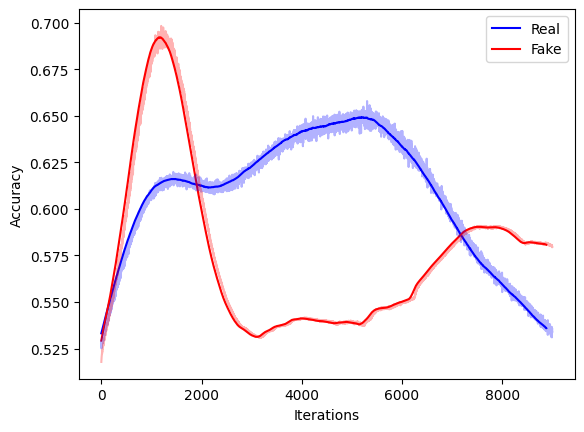

In [50]:
import numpy as np

# Smooth the curve
def smooth_data(x,ksize=5):
    kernel = np.ones(ksize)/ksize
    x_smooth = np.convolve(x,kernel,mode='valid')
    return x_smooth

acc_r_smooth = smooth_data(acc_r,120)
acc_f_smooth = smooth_data(acc_f,120)

plt.plot(acc_r_smooth,'-b',label='Real')
plt.plot(acc_f_smooth,'-r',label='Fake')
plt.plot(acc_r,'-b',alpha=0.3)
plt.plot(acc_f,'-r',alpha=0.3)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()

GAN  改优化算法 与学习率试试 (5e-3, 1e-3,5e-4,1e-4,5e-5,1e-5,5e-6)

In [51]:
z_dim = 20
netD = Discriminator().to(device)
netG = Generator(z_dim).to(device)

optimizerD= torch.optim.SGD(netD.parameters(),lr=5e-3,momentum=0.9)
optimizerG= torch.optim.RMSprop(netG.parameters(),lr=5e-3)
nepochs = 15

criterion = nn.BCELoss()
one = torch.ones(BATCH_SIZE,1).to(device)
zero = torch.zeros(BATCH_SIZE,1).to(device)

acc_r = []
acc_f = []
for epoch in range(nepochs):
    since = time.time()
    for batch_x, _ in dataloader:
        real_size = batch_x.size(0)
        real_x = batch_x.to(device)
    
        # 更新判别器
        z = torch.randn(BATCH_SIZE,z_dim).to(device)
        fake_x = netG(z)
        
        # 计算判别器的损失
        optimizerD.zero_grad()
        real_y = netD(real_x)
        fake_y = netD(fake_x)
        
        rea_label = torch.ones(real_size,1).to(device)
        fake_label = torch.zeros(real_size,1).to(device)
        
        errorD_real = criterion(real_y,rea_label)
        errorD_fake = criterion(fake_y,fake_label)
        
        errorD = errorD_real + errorD_fake
        errorD.backward()
        optimizerD.step()
        
        acc_r.append(real_y.mean().item())
        acc_f.append(fake_y.mean().item())
        
        # 更新生成器
        optimizerG.zero_grad()
        z = torch.randn(real_size,z_dim).to(device)
        fake_x = netG(z)
        fake_y = netD(fake_x)
        errorG = criterion(fake_y,rea_label)
        errorG.backward()
        optimizerG.step()
        
    now = time.time()
    print('[%d/%d, %.0f seconds]|\t err_D: %.4f \t err_G: %.4f' % (epoch, nepochs, now-since, errorD.item(), errorG.item()))
    


[0/15, 10 seconds]|	 err_D: 0.0008 	 err_G: 7.8838
[1/15, 10 seconds]|	 err_D: 0.0003 	 err_G: 8.4337
[2/15, 10 seconds]|	 err_D: 0.0000 	 err_G: 100.0000
[3/15, 10 seconds]|	 err_D: 0.0000 	 err_G: 100.0000
[4/15, 10 seconds]|	 err_D: 0.0000 	 err_G: 100.0000
[5/15, 10 seconds]|	 err_D: 0.0000 	 err_G: 100.0000
[6/15, 10 seconds]|	 err_D: 0.0000 	 err_G: 100.0000
[7/15, 10 seconds]|	 err_D: 0.0000 	 err_G: 100.0000
[8/15, 10 seconds]|	 err_D: 0.0000 	 err_G: 100.0000
[9/15, 9 seconds]|	 err_D: 0.0000 	 err_G: 100.0000
[10/15, 10 seconds]|	 err_D: 0.0000 	 err_G: 99.8316
[11/15, 10 seconds]|	 err_D: 0.0000 	 err_G: 100.0000
[12/15, 10 seconds]|	 err_D: 0.0000 	 err_G: 100.0000
[13/15, 10 seconds]|	 err_D: 0.0000 	 err_G: 100.0000
[14/15, 10 seconds]|	 err_D: 0.0000 	 err_G: 100.0000


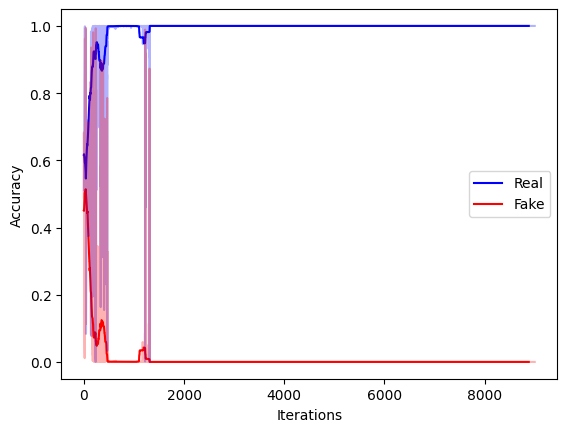

In [52]:
import numpy as np

# Smooth the curve
def smooth_data(x,ksize=5):
    kernel = np.ones(ksize)/ksize
    x_smooth = np.convolve(x,kernel,mode='valid')
    return x_smooth

acc_r_smooth = smooth_data(acc_r,120)
acc_f_smooth = smooth_data(acc_f,120)

plt.plot(acc_r_smooth,'-b',label='Real')
plt.plot(acc_f_smooth,'-r',label='Fake')
plt.plot(acc_r,'-b',alpha=0.3)
plt.plot(acc_f,'-r',alpha=0.3)
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()